# Option Chain Return Plot
This notebook will grab the option chain for a given stock and expiration date from Tradier's sandbox API and, given an expected price, graph the percent return for either put or call options should the stock be at that price on the expiration date.

### Notes
1. The data from Tradier's sandbox is delayed by up to a day. This should not be used for making actual investment decisions.
2. This is an _extremely_ simple model of option valuation. It assumes you hold the option until the expiration date and exercise it. It does not take into account any value fluctuation over the time you hold the option.
3. This is a really rough notebook. Errors and unexpected values will generate tracebacks, not useful messages.

### Option Value Formula
% Return = (Strike - ExpectedPrice - Ask) / Ask

### Requirements
You must sign up for a developer account at Tradier to use the API

### Usage:
```
best_value(symbol, expiry, expected_price=??)
ex:
best_value("GME", "2021-02-26", expected_price=20)
```

In [1]:
TRADIER_API_TOKEN = #SIGN UP AT DEVELOPER.TRADIER.COM

In [2]:
import requests
from matplotlib import pyplot as plt

In [3]:
def make_call(url, params):
    url = "https://sandbox.tradier.com/v1/%s" % url
    headers = {"Authorization": "Bearer %s" % TRADIER_API_TOKEN, "Accept": "application/json"}
    return requests.get(url, params=params, headers=headers).json()

def get_chains(symbol, expiry):
    url = "markets/options/chains"
    params = {"symbol": symbol, "expiration": expiry}
    return make_call(url, params)["options"]["option"]

def get_price(symbol):
    url = "markets/quotes"
    params = {"symbols": symbol}
    return make_call(url, params)["quotes"]["quote"]["last"]

In [4]:
# Helper functions

def overall(option, expected_price):
    return option["strike"], option["ask"], option['strike'] - expected_price, pct_ret(option, expected_price)

def pct_ret(option, expected_price):
    value = (option['strike'] - expected_price) - option['ask']
    pct_ret = float(value) / option['ask']
    return pct_ret * 100

def puts_and_calls(options):
    puts = []
    calls = []
    for option in options:
        if option["option_type"] == "put":
            puts.append(option)
        elif option["option_type"] == "call":
            calls.append(option)
    return puts, calls

def makeplot(plt, strike, ret, max_ret, price):
    plt.rcParams['figure.figsize'] = [8, 6]
    fig = plt.figure()
    ax = plt.axes()
    plt.grid()
    plt.ylim(-1, (max(ret)+5))
    plt.xlabel("Strike")
    plt.ylabel("Return (pct)")
    plt.plot(strike, ret, label="Expected return at %s" % price)
    plt.title("Max return: %d%% (\$%d) at strike %d (ask %d)" % (
        max_ret[3], (max_ret[3] * max_ret[1]) / 100, max_ret[0], max_ret[1]))
    plt.show()

def get_values(options, expected_price):
    values = [overall(o, expected_price) for o in options]
    strike = [i[0] for i in values]
    ret = [i[3] for i in values]
    max_ret = sorted(values, key=lambda i: -i[3])[0]
    return strike, ret, max_ret


In [5]:
def best_return(symbol, expiry, expected_price, puts=True):
    """Plot the percent returns for the option chain for the symbol, expiration, and price given.
    
    Params:
        symbol: String: the stock symbol to check
        expiry: String: Expiration date, formatted as YYYY-MM-DD
        expected_price: Numeric: Price you expect the stock to be at expiry
        puts: Bool[True]: Check puts if true, calls if false
    
    Returns:
        Graph showing return curve for options
    """
    options = get_chains(symbol, expiry)
    puts, calls = puts_and_calls(options)
    if puts:
        options = puts
    else:
        options = calls
    strike, ret, max_ret = get_values(options, expected_price)
    makeplot(plt, strike, ret, max_ret, expected_price)

In [6]:
get_price("gme")

147.98

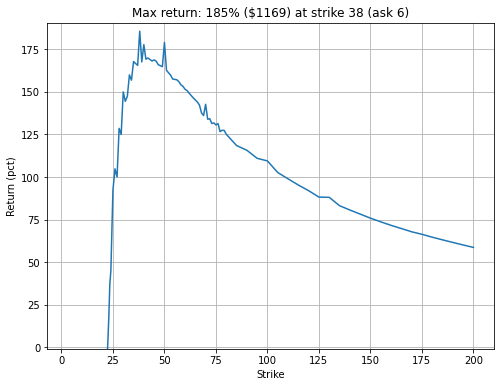

In [7]:
best_return("GME", "2021-02-26", expected_price=20)